In [1]:
import os

os.chdir("../src")

from utils import data_utils

import pandas as pd
import numpy as np
import anndata as ad

pd.set_option("display.max_columns", None)

In [2]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch import Tensor
from typing import List, Tuple, Optional
from argparse import Namespace
from sklearn.model_selection import train_test_split
import scanpy as sc

In [7]:
# Note: only preprosessing, which keeps 0 as 0 is allowed as 0 means no expression
def prepare_data(val_frac: float) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]:
    data = data_utils.load_anndata(mode='train', plus_iid_holdout=True)
    data = data[data.obs["is_train"].apply(lambda x: x in ['train', 'iid_holdout'])]
    
    tensor_data = torch.tensor(data.X.A)
    celltype  = data.obs['cell_type'].cat.codes.values
    batch_id = data.obs['batch'].cat.codes.values
    del data
    nonzero_median = tensor_data[tensor_data > 0].median(dim=0, keepdim=True).values
    tensor_data = tensor_data / nonzero_median
    del nonzero_median
    train_tensor_data, val_tensor_data, train_celltype, val_celltype, train_batch_id, val_batch_id = train_test_split(tensor_data, celltype, batch_id, test_size=val_frac, random_state=0)
    return train_tensor_data, val_tensor_data, train_celltype, val_celltype, train_batch_id, val_batch_id

In [8]:
train_tensor_data, val_tensor_data, train_celltype, val_celltype, train_batch_id, val_batch_id = prepare_data(val_frac=0.1)

d:\bioml\.venv\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Subsampling anndata with fraction 1.0...


In [9]:
train_tensor_data.shape, val_tensor_data.shape

(torch.Size([67675, 14087]), torch.Size([7520, 14087]))

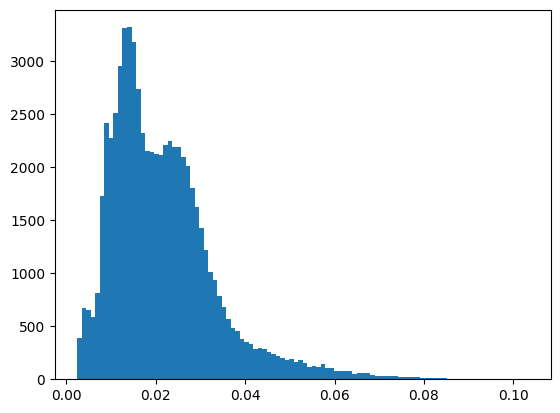

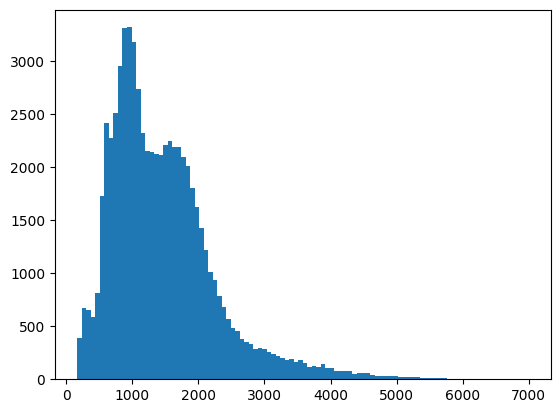

In [14]:
import matplotlib.pyplot as plt

# ((train_tensor_data > 0).sum(dim=1) / train_tensor_data.shape[0]).shape

plt.hist((train_tensor_data > 0).sum(dim=1) / train_tensor_data.shape[0], bins=100)
plt.show()
plt.hist((train_tensor_data > 0).sum(dim=1), bins=100)
plt.show()
# (val_tensor_data > 0).sum(dim=1) / val_tensor_data.shape[0]

### Description of the model
I do embedding via small neural network taking small gene emebddings and expression level and creates an embedding - the combination here is more complex than just adding the "positional embedding = gene embeddings" and the gene expression level embedding. The reconstruction allows then to treat the values as continous after attaching the regression head to the output token embeddings. 

Note, that at no time we have to predict tokens.
Other methods for doing embeddings:
1) binning and quantization of the expression values into discrete tokens: + we have convenient tokens for both genes and expressions separately, - we lose information
2) network for embedding scalar as vector and adding it to learned gene embeddings
Pooled token is added to the gene embeddings at the decoder input to allow the model to condition on the gene expression values. The model is trained to predict the gene expression values from the decoder output. So we are not attaching classification head to the decoder output but regression head.

I choose to do a simmilar thing as was done to create coembeddings od genes and expressions in the encoder part with the hiddens state and the gene embedding. Note, that different choices in the prvious point would result in different possibilities here. Especially solution 1 allows for just taking gene embeddings without adding the token embedding fo the quantized expression values.

The approach is considered to be more robust to sparsity of data and allow to create representations for different sets of genes.

Masked modelling does not make too much sense as the info about having a gene or not is a matter of acces to data and should not impact the token embedding process. Adding additional genes makes sense in the decoder part and is important to ensure that nonexpressed genes are indeed nonexpressed and the ones not included in the input are reconstructed as well and that rarely expressed genes token embeddings are influenced by the training.

The question concering the GeneChoice Module is weathe we should make the model robust to differing numbers of inputs - this seems reasonable, but I leave it for simplicity for now.

TODO: Consider different stabilising methods like Layer Norm of the embeddings. Think of using KAN or MOE in the feedforward part of the transformer.

In [8]:
# This class relies on the fixed order of the genes in the input tensor, but it may be extended to support a more general case
# in practice it would be great to be independent of the order and only pass labels of the genes we have acces to
# (but actually the model is not trained to handle lack of highly expressed genes, so random removal of such genes supported by perhaps another mechanism would be needed to gain robustness to sparse inputs)
# the same for the number of genes
class GeneChoiceModule():
    def __init__(self, num_genes_total: int, default_num_input_genes: int, default_num_auxilary_decoded_genes: int, auxilary_gene_choice_mode: str) -> None:
        self.num_genes_total = num_genes_total
        self.default_num_input_genes = default_num_input_genes
        self.default_num_auxilary_decoded_genes = default_num_auxilary_decoded_genes
        self.auxilary_gene_choice_mode = auxilary_gene_choice_mode
    
    def choose(self, x: Tensor, num_input_genes: Optional[int] = None, num_auxilary_decoded_genes: Optional[int] = None) -> Tuple[List[int], List[int]]:
        assert x.shape[1] == self.num_genes_total, f"Expected {self.num_genes_total} genes, got {x.shape[1]}. Something is wrong with the input tensor."
        num_input_genes = num_input_genes if num_input_genes is not None else self.default_num_input_genes
        num_auxilary_decoded_genes = num_auxilary_decoded_genes if num_auxilary_decoded_genes is not None else self.default_num_auxilary_decoded_genes

        idxs = x.argsort(descending=True, dim=1) # order by expression level
        input_gene_idxs = idxs[:, :num_input_genes] # choose the most expressed genes
        rest_gene_idxs = idxs[:, num_input_genes:] # separate the rest of the genes
        if self.auxilary_gene_choice_mode == "sample_from_left":
            permutation_idxs = torch.argsort(torch.randn(x.shape[0], self.num_genes_total - num_input_genes), dim=1) # random permutation for each sample independentyly
            aux_gene_idxs = torch.gather(rest_gene_idxs, dim=1, index=permutation_idxs)[:, :num_auxilary_decoded_genes]
        # elif self.auxilary_gene_choice_mode == "sample_from_nonexpressed":
        else:
            raise ValueError("Invalid auxilary_gene_choice")
        return input_gene_idxs, aux_gene_idxs

def test_gene_choice_module():
    gene_choice_module = GeneChoiceModule(10, 5, 3, "sample_from_left")
    x = torch.randn(2, 10).argsort(dim=1)
    input_gene_idxs, aux_gene_idxs = gene_choice_module.choose(x)
    print('x:', x)
    print('input_gene_idxs:', input_gene_idxs)
    print('aux_gene_idxs:', aux_gene_idxs)

test_gene_choice_module()

x: tensor([[1, 4, 8, 6, 0, 9, 5, 3, 7, 2],
        [3, 0, 9, 6, 7, 1, 5, 8, 2, 4]])
input_gene_idxs: tensor([[5, 2, 8, 3, 6],
        [2, 7, 4, 3, 6]])
aux_gene_idxs: tensor([[1, 9, 0],
        [9, 8, 1]])


In [9]:
class EmbeddingModule():
    def __init__(self, num_gene_embeddings: int, gene_embedding_dim: int, embedding_dim: int, latent_dim: int) -> None:
        # gene encoder is used for creating embeddings in both encoder and decoder
        self.gene_embed = nn.Embedding(num_gene_embeddings, gene_embedding_dim) # we take smaller gene embedding dim to reduce the number of parameters
        self.pool_embed = nn.Parameter(torch.empty((1, embedding_dim))) # used for pooling of the embeddings in the encoder
        nn.init.xavier_normal_(self.pool_embed)
        # cross encoder used for combining gene embeddings with expression levels in the encoder
        self.cross_embed_gene_express_lvl = nn.Sequential(
            nn.Linear(in_features=1 + gene_embedding_dim, out_features=embedding_dim),
            nn.SELU(),
            nn.Linear(in_features=embedding_dim, out_features=embedding_dim),
        )
        # cross encoder used for combining gene embeddings with latent variables in the decoder
        # actually it could be named latent decoder, but there are some naming conflicts
        self.cross_embed_gene_latent = nn.Sequential(
            nn.Linear(in_features=gene_embedding_dim + latent_dim, out_features=embedding_dim),
            nn.SELU(),
            nn.Linear(in_features=embedding_dim, out_features=embedding_dim),
        )

    def embed_genes(self, genes_idxs: Tensor) -> Tensor:
        return self.gene_embed(genes_idxs)

    def embed_genes_and_expression_levels(self, genes_idxs: Tensor, expressions: Tensor) -> Tensor:
        return self.cross_embed_gene_express_lvl(torch.cat([self.embed_genes(genes_idxs), expressions.unsqueeze(-1)], dim=2))
    
    def embed_genes_and_latent_vars(self, genes_idxs: Tensor, z: Tensor) -> Tensor:
        _, num_bow_genes = genes_idxs.shape
        return self.cross_embed_gene_latent(torch.cat([self.embed_genes(genes_idxs), z.unsqueeze(dim=1).repeat(1, num_bow_genes, 1)], dim=2)) # the dim=1 in unsqueeze is important, because we want to add the latent variable to each gene separately

def test_embedding_module():
    embedding_module = EmbeddingModule(10, 5, 3, 2)
    genes = torch.randint(0, 10, (2, 10))
    expressions = torch.randn(2, 10)
    z = torch.randn(2, 2)
    print('genes:', genes.shape)
    print('z:', z.shape)
    print('pool:', embedding_module.pool_embed.shape)
    print('embed_genes:', embedding_module.embed_genes(genes).shape)
    print('embed_genes_and_expression_levels:', embedding_module.embed_genes_and_expression_levels(genes, expressions).shape)
    print('embed_genes_and_latent_vars:', embedding_module.embed_genes_and_latent_vars(genes, z).shape)

test_embedding_module()

genes: torch.Size([2, 10])
z: torch.Size([2, 2])
pool: torch.Size([1, 3])
embed_genes: torch.Size([2, 10, 5])
embed_genes_and_expression_levels: torch.Size([2, 10, 3])
embed_genes_and_latent_vars: torch.Size([2, 10, 3])


In [10]:
class CustomTransformerBlock(nn.Module):
    def __init__(self, embedding_dim: int, num_heads: int, hidden_dim: int) -> None:
        super().__init__()
        self.multi_head_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads)
        self.qkv = nn.Linear(in_features=embedding_dim, out_features=embedding_dim * 3)
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=hidden_dim),
            nn.SELU(),
            nn.Linear(in_features=hidden_dim, out_features=embedding_dim)
        )
        self.lnorm1 = nn.LayerNorm(embedding_dim)
        self.lnorm2 = nn.LayerNorm(embedding_dim)
    
    def forward(self, x: Tensor) -> Tensor:
        # expected input shape (batch_size, set_size, embedding_dim)
        x = self.lnorm1(x) # pre-norm
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        x = self.multi_head_attention(q, k, v)[0] + x
        x = self.lnorm2(x) # pre-norm
        x = self.ffn(x) + x
        return x

def test_encoder_block():
    encoder_block = CustomTransformerBlock(10, 2, 5)
    x = torch.randn(2, 10, 10)
    print('x:', x.shape)
    print('encoder_block:', encoder_block(x).shape)

test_encoder_block()        

x: torch.Size([2, 10, 10])
encoder_block: torch.Size([2, 10, 10])


In [11]:
class VAEEncoderHead(nn.Module):
    def __init__(self, embedding_dim: int, latent_dim) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=embedding_dim),
            nn.SELU(),
            nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        )
        self.mulogvar = nn.Linear(in_features=embedding_dim, out_features=2 * latent_dim)
        
    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        x = self.encoder(x)
        mu, logvar = self.mulogvar(x).chunk(2, dim=-1)
        sigma = logvar.exp()**0.5
        eps = torch.randn_like(mu)
        z = mu + sigma * eps
        return z, mu, sigma
    
    def kld(self, mu: Tensor, logvar: Tensor) -> Tensor:
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def test_latent_encoder():
    latent_encoder = VAEEncoderHead(10, 4)
    x = torch.randn(2, 10)
    print('x:', x.shape)
    z, mu, sigma = latent_encoder(x)
    print('z:', z.shape)
    print('mu:', mu.shape)
    print('sigma:', sigma.shape)

test_latent_encoder()

x: torch.Size([2, 10])
z: torch.Size([2, 4])
mu: torch.Size([2, 4])
sigma: torch.Size([2, 4])


In [12]:
class RegressionHead(nn.Module):
    def __init__(self, embedding_dim: int) -> None:
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=embedding_dim),
            nn.SELU(),
            nn.Linear(in_features=embedding_dim, out_features=1)
        )
    
    def forward(self, x: Tensor) -> Tensor:
        # expected input shape (batch_size, num_genes, embedding_dim)
        return self.regressor(x)

def test_regression_head():
    regression_head = RegressionHead(10)
    x = torch.randn(2, 10, 10)
    print('x:', x.shape)
    print('regression_head:', regression_head(x).shape)

test_regression_head()

x: torch.Size([2, 10, 10])
regression_head: torch.Size([2, 10, 1])


In [26]:
class TransformerAE(pl.LightningModule):
    def __init__(self, cfg: Namespace):
        super().__init__()
        self.cfg = cfg
        self.gene_choice_module = GeneChoiceModule(num_genes_total=cfg.model.num_genes, default_num_input_genes=cfg.gene_choice.default_num_input_genes, default_num_auxilary_decoded_genes=cfg.gene_choice.default_num_auxilary_decoded_genes, auxilary_gene_choice_mode=cfg.gene_choice.auxilary_gene_choice_mode)
        self.embedding_module = EmbeddingModule(num_gene_embeddings=cfg.model.num_genes, gene_embedding_dim=cfg.model.gene_embedding_dim, embedding_dim=cfg.model.embedding_dim, latent_dim=cfg.model.latent_dim)
        self.encoder_body = nn.Sequential(*[CustomTransformerBlock(embedding_dim=cfg.model.embedding_dim, num_heads=cfg.model.num_heads, hidden_dim=cfg.model.feedforward_hidden_dim) for _ in range(cfg.model.num_blocks_encoder)])
        self.encoder_head = VAEEncoderHead(embedding_dim=cfg.model.embedding_dim, latent_dim=cfg.model.latent_dim)
        self.decoder = nn.Sequential(*[CustomTransformerBlock(embedding_dim=cfg.model.embedding_dim, num_heads=cfg.model.num_heads, hidden_dim=cfg.model.feedforward_hidden_dim) for _ in range(cfg.model.num_blocks_decoder)])
        self.regression_head = RegressionHead(embedding_dim=cfg.model.embedding_dim)

    def encode(self, gene_idxs: Tensor, expression_lvls: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        batch_size, _ = gene_idxs.shape
        x = self.embedding_module.embed_genes_and_expression_levels(gene_idxs, expression_lvls) # (batch_size, num_genes, embedding_dim)
        # adding the pool embedding to the input. potentially more expressive than just averaging the embeddings, but more computations required
        # I am concerned, that it is not the best though as the embeddings for the genes may collapse to the same value perhaps to pass more info through the pool embedding
        x = torch.cat([self.embedding_module.pool_embed.repeat(batch_size, 1, 1), x], dim=1) # (batch_size, num_genes + 1, embedding_dim)
        pooled_representation = self.encoder_body(x)[:, 0, :]
        z, mu, sigma = self.encoder_head(pooled_representation)
        return z, mu, sigma
    
    def decode(self, gene_idxs: Tensor, z: Tensor) -> Tensor:
        # gene_idxs: (batch_size, num_genes), z: (batch_size, latent_dim)
        x = self.embedding_module.embed_genes_and_latent_vars(gene_idxs, z) # (batch_size, num_genes, embedding_dim)
        x = self.decoder(x)
        x = self.regression_head(x)
        return x.squeeze(-1)

    def training_step(self, x: Tensor) -> Tensor:
        # x: (batch_size, num_genes) - contains normalized sparse expression levels for all genes
        # choosing the genes to be passed to the encoder and decoder as well as auxilary ones to be just decoded
        x = x[0] # extract the tensor from the one element list
        assert x.shape[1] == self.cfg.model.num_genes, f"Expected {self.cfg.model.num_genes} genes, got {x.shape[1]}. Something is wrong with the input tensor."
        encoder_input_gene_idxs, aux_gene_idxs = self.gene_choice_module.choose(x)
        assert encoder_input_gene_idxs.shape == (x.shape[0], self.cfg.gene_choice.default_num_input_genes), f"Expected {(x.shape[0], self.cfg.gene_choice.default_num_input_genes)}, got {encoder_input_gene_idxs.shape}. Something is wrong with the gene choice module."
        assert aux_gene_idxs.shape == (x.shape[0], self.cfg.gene_choice.default_num_auxilary_decoded_genes), f"Expected {(x.shape[0], self.cfg.gene_choice.default_num_auxilary_decoded_genes)}, got {aux_gene_idxs.shape}. Something is wrong with the gene choice module."
        encoder_input_exprs_lvls = torch.gather(x, dim=1, index=encoder_input_gene_idxs)
        assert encoder_input_exprs_lvls.shape == (x.shape[0], self.cfg.gene_choice.default_num_input_genes), f"Expected {(x.shape[0], self.cfg.gene_choice.default_num_input_genes)}, got {encoder_input_exprs_lvls.shape}. Something is wrong with the input tensor."
        aux_exprs_lvls = torch.gather(x, dim=1, index=aux_gene_idxs)
        assert aux_exprs_lvls.shape == (x.shape[0], self.cfg.gene_choice.default_num_auxilary_decoded_genes), f"Expected {(x.shape[0], self.cfg.gene_choice.default_num_auxilary_decoded_genes)}, got {aux_exprs_lvls.shape}. Something is wrong with the input tensor."
        z, mu, sigma = self.encode(encoder_input_gene_idxs, encoder_input_exprs_lvls)
        assert z.shape == (x.shape[0], self.cfg.model.latent_dim), f"Expected {(x.shape[0], self.cfg.model.latent_dim)}, got {z.shape}. Something is wrong with the encoder."
        decoder_input_gene_idxs = torch.cat([encoder_input_gene_idxs, aux_gene_idxs], dim=1)
        assert decoder_input_gene_idxs.shape == (x.shape[0], self.cfg.gene_choice.default_num_input_genes + self.cfg.gene_choice.default_num_auxilary_decoded_genes), f"Expected {(x.shape[0], self.cfg.gene_choice.default_num_input_genes + self.cfg.gene_choice.default_num_auxilary_decoded_genes)}, got {decoder_input_gene_idxs.shape}. Something is wrong with the gene choice module."
        decoder_input_exprs_lvls = torch.cat([encoder_input_exprs_lvls, aux_exprs_lvls], dim=1)
        assert decoder_input_exprs_lvls.shape == (x.shape[0], self.cfg.gene_choice.default_num_input_genes + self.cfg.gene_choice.default_num_auxilary_decoded_genes), f"Expected {(x.shape[0], self.cfg.gene_choice.default_num_input_genes + self.cfg.gene_choice.default_num_auxilary_decoded_genes)}, got {decoder_input_exprs_lvls.shape}. Something is wrong with the input tensor."
        exprs_hat = self.decode(decoder_input_gene_idxs, z)
        assert exprs_hat.shape == decoder_input_exprs_lvls.shape, f"Expected {decoder_input_exprs_lvls.shape}, got {exprs_hat.shape}. Something is wrong with the decoder."
        kld_loss = self.encoder_head.kld(mu, sigma)
        reconstr_loss = nn.functional.mse_loss(exprs_hat, decoder_input_exprs_lvls)
        
        self.log('train_reconstr_loss', reconstr_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_kld_loss', kld_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return reconstr_loss + self.cfg.losses.kld_weight * kld_loss
    
    def validation_step(self, x: Tensor) -> Tensor:
        # x: (batch_size, num_genes) - contains normalized sparse expression levels for all genes
        x = x[0]
        encoder_input_gene_idxs, aux_gene_idxs = self.gene_choice_module.choose(x)
        encoder_input_exprs_lvls = torch.gather(x, dim=1, index=encoder_input_gene_idxs)
        aux_exprs_lvls = torch.gather(x, dim=1, index=aux_gene_idxs)
        z, mu, sigma = self.encode(encoder_input_gene_idxs, encoder_input_exprs_lvls)
        decoder_input_gene_idxs = torch.cat([encoder_input_gene_idxs, aux_gene_idxs], dim=1)
        decoder_input_exprs_lvls = torch.cat([encoder_input_exprs_lvls, aux_exprs_lvls], dim=1)
        exprs_hat = self.decode(decoder_input_gene_idxs, z)
        kld_loss = self.encoder_head.kld(mu, sigma)
        assert exprs_hat.shape == decoder_input_exprs_lvls.shape, f"Expected {decoder_input_exprs_lvls.shape}, got {exprs_hat.shape}. Something is wrong with the decoder."
        reconstr_loss = nn.functional.mse_loss(exprs_hat, decoder_input_exprs_lvls)
        
        self.log('val_reconstr_loss', reconstr_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_kld_loss', kld_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return reconstr_loss + self.cfg.losses.kld_weight * kld_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.cfg.training.optimizer.lr)
        return optimizer


In [14]:
# be flexible about the configuration
# the goal is to move to hydra configuration, but for now it is a bit too much. yet hydra uses yaml so moving to it would be easy after learning the basics
# regression loss could be configurable as well
cfg_dict = {
    "model": {
        "num_genes": 14087,
        "gene_embedding_dim": 8,
        "embedding_dim": 16,
        "latent_dim": 16,
        "num_heads": 2,
        "feedforward_hidden_dim": 24,
        "num_blocks_encoder": 1,
        "num_blocks_decoder": 1,
        },
    "gene_choice": {
        "default_num_input_genes": 256,
        "default_num_auxilary_decoded_genes": 128,
        "auxilary_gene_choice_mode": "sample_from_left"
        },
    "training": {
        "batch_size": 64,
        "optimizer": {
            "lr": 1e-3,
        },
        "n_epochs": 2,
        },
    "losses": {
        "kld_weight": 0.01,
    }
}

def dict_to_namespace(d):
    """
    Recursively converts a dictionary into a Namespace object.
    """
    for key, value in d.items():
        if isinstance(value, dict):
            d[key] = dict_to_namespace(value)
    return Namespace(**d)

cfg = dict_to_namespace(cfg_dict)

TODO verify weather the dimensions are processed correctly in the model.

In [15]:
train_tensor_dataset = torch.utils.data.TensorDataset(train_tensor_data)
train_loader = torch.utils.data.DataLoader(train_tensor_dataset, batch_size=cfg.training.batch_size, shuffle=True)
val_tensor_dataset = torch.utils.data.TensorDataset(val_tensor_data)
val_loader = torch.utils.data.DataLoader(val_tensor_dataset, batch_size=cfg.training.batch_size, shuffle=False)

In [16]:
next(iter(train_loader))[0].shape

torch.Size([64, 14087])

In [17]:
trainer = pl.Trainer(max_epochs=cfg.training.n_epochs)
model = TransformerAE(cfg)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\bioml\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Note, that the reconstruction loss here cannot be directly compare to the reconstruction loss in the methods which input all the genes at all times because of the different number of genes in the input. The reconstruction loss is calculated only for the genes that are present in the input. The question is weather it is harder or easier task.

In [30]:
trainer.fit(model, train_loader, val_loader)

d:\bioml\.venv\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name            | Type           | Params
---------------------------------------------------
0 | encoder_body    | Sequential     | 2.8 K 
1 | encoder_head    | VAEEncoderHead | 1.1 K 
2 | decoder         | Sequential     | 2.8 K 
3 | regression_head | RegressionHead | 289   
---------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
d:\bioml\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1058/1058 [06:50<00:00,  2.57it/s, v_num=10, train_reconstr_loss_step=1.960, train_kld_loss_step=0.135, train_reconstr_loss_epoch=1.140, train_kld_loss_epoch=0.483]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1058/1058 [06:50<00:00,  2.57it/s, v_num=10, train_reconstr_loss_step=1.960, train_kld_loss_step=0.135, train_reconstr_loss_epoch=1.140, train_kld_loss_epoch=0.483]


### Load the model checkpoint

In [18]:
# Access the path to the best checkpoint (according to monitored metric, e.g., validation loss)
best_checkpoint_path = trainer.checkpoint_callback.best_model_path
print(f"Best checkpoint path: {best_checkpoint_path}")

# If you just want the last checkpoint saved, regardless of performance:
last_checkpoint_path = trainer.checkpoint_callback.last_model_path
print(f"Last checkpoint path: {last_checkpoint_path}")

Best checkpoint path: 
Last checkpoint path: 


In [19]:
os.curdir
os.listdir(os.curdir)

['config',
 'evaluation cls.ipynb',
 'evaluation-umap-pca-entropy-leiden.ipynb',
 'evaluation.ipynb',
 'evaluation2.ipynb',
 'evaluation3.ipynb',
 'latent_analysis.py',
 'lightning_logs',
 'metrics.py',
 'models',
 'train.py',
 'train_and_validate.py',
 'utils',
 '__init__.py']

In [20]:
model = TransformerAE.load_from_checkpoint("lightning_logs/version_10/checkpoints/epoch=1-step=2116.ckpt", cfg=cfg)

### UMAP on the embeddings

In [21]:
def get_data_embeddings(tensor_dataset: torch.utils.data.TensorDataset, model: TransformerAE) -> Tuple[Tensor, Tensor]:
    dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=128, shuffle=False)
    sampled_embeddings = []
    mu_embeddings = []
    for x in dataloader:
        x = x[0]
        encoder_input_gene_idxs, aux_gene_idxs = model.gene_choice_module.choose(x)
        encoder_input_exprs_lvls = torch.gather(x, dim=1, index=encoder_input_gene_idxs)
        z, mu, _ = model.encode(encoder_input_gene_idxs, encoder_input_exprs_lvls)
        sampled_embeddings.append(z)
        mu_embeddings.append(mu)
    sampled_embeddings = torch.cat(sampled_embeddings, dim=0)
    mu_embeddings = torch.cat(mu_embeddings, dim=0)
    return sampled_embeddings, mu_embeddings

In [22]:
import umap

sampled_embeddings, mu_embeddings = get_data_embeddings(val_tensor_dataset, model) # using validation dataset
sampled_embeddings_umap = umap.UMAP(n_components=2).fit_transform(sampled_embeddings.detach().numpy())

d:\bioml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


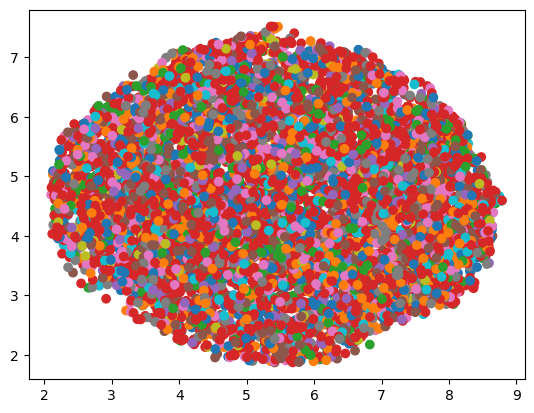

In [25]:
import matplotlib.pyplot as plt

plt.scatter(sampled_embeddings_umap[:, 0], sampled_embeddings_umap[:, 1], c=val_celltype, cmap='tab10')
plt.show()